In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold


%matplotlib inline

In [2]:
df = pd.read_csv('data.csv')

In [3]:
features = ["Make",
"Model",
"Year",
"Engine HP",
"Engine Cylinders",
"Transmission Type",
"Vehicle Style",
"highway MPG",
"city mpg",
"MSRP"]

In [4]:
df = df[features]

In [5]:
df.head()

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [6]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

In [7]:
df.fillna(0, inplace=True)

In [8]:
df["above_average"] = (df.msrp>= df.msrp.mean()).astype(int)

In [9]:
del df['msrp']

In [10]:
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,0


In [11]:
df_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full, test_size=0.25, random_state=1)

In [12]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [13]:
#y_full = df_full["above_average"].values
y_train = df_train["above_average"].values
y_val = df_val["above_average"].values
y_test = df_test["above_average"].values

#del df_full["above_average"]
del df_train["above_average"]
del df_val["above_average"]
del df_test["above_average"]

In [45]:
categorical = list(df_train.dtypes[df.dtypes == 'object'].index)
numerical = [x for x in list(df_train.columns) if x not in categorical]

In [46]:
categorical

['make', 'model', 'transmission_type', 'vehicle_style']

In [47]:
numerical

['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

Question 1

In [51]:
for i in numerical:
    auc = roc_auc_score(y_train, df_train[i].values)
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[i].values)
    print(i, auc)

year 0.6928273411060888
engine_hp 0.9164757999917978
engine_cylinders 0.7671850522495359
highway_mpg 0.6316523655095094
city_mpg 0.6723270402704458


Question 2

In [16]:
dv = DictVectorizer(sparse=False)

In [17]:
train_dict = df_train.to_dict(orient="records")

In [18]:
dv.fit(train_dict)

DictVectorizer(sparse=False)

In [19]:
X_train = dv.transform(train_dict)

In [20]:
X_train.shape

(7148, 954)

In [21]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [22]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [23]:
val_dict = df_val.to_dict(orient="records")
X_val = dv.transform(val_dict)

In [24]:
y_pred = model.predict_proba(X_val)[:, 1]

In [25]:
roc_auc_score(y_val, y_pred)

0.9802249094861359

Question 3

In [26]:
thresholds = np.arange(0, 1.01, 0.01)

In [27]:
scores = []
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    scores.append((t, p, r))

C:\Users\abdul\AppData\Local\Temp\ipykernel_29312\2719419167.py:15: RuntimeWarning: invalid value encountered in long_scalars
  p = tp / (tp + fp)


In [28]:
columns = ['threshold', 'precission', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

In [29]:
df_scores.head()

,threshold,precission,recall
0,0.00,0.274444,1.000000
1,0.01,0.454039,0.996942
2,0.02,0.503480,0.995413
3,0.03,0.532298,0.995413
4,0.04,0.567686,0.993884


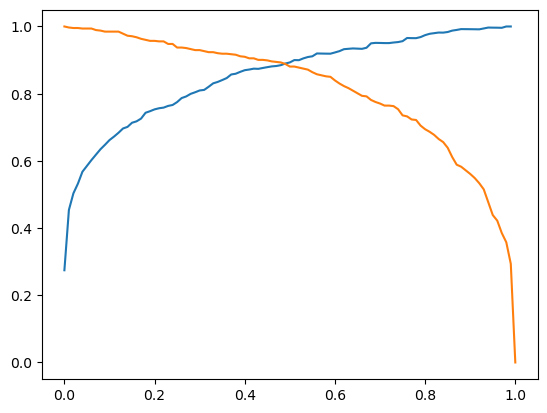

In [30]:
plt.plot(df_scores.threshold, df_scores['precission'])
plt.plot(df_scores.threshold, df_scores['recall'])

Question 4

In [31]:
df_scores['F1'] = 2*df_scores.precission*df_scores.recall/(df_scores.precission+df_scores.recall)

In [32]:
df_scores.loc[df_scores.F1 == max(df_scores['F1'])]

,threshold,precission,recall,F1
51,0.51,0.9,0.880734,0.890263


Question 5

In [44]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full):
    df_train = df_full.iloc[train_idx]
    df_val = df_full.iloc[train_idx]
    
    y_train = df_train['above_average'].values
    y_val = df_val['above_average'].values
    
    del df_train['above_average']
    del df_val['above_average']
    
    train_dict_full = df_train.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dict_full)

    val_dict_full = df_val.to_dict(orient='records')
    X_val =dv.transform(val_dict_full)
                                   
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    
    scores.append(roc_auc_score(y_val, y_pred))

print(round(np.std(np.array(scores)),3))

0.003


Question 6

In [43]:
n_folds = 5

C = [0.01, 0.1, 0.5, 10]

for c in C:
    scores = []
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=1)
    for train_idx, val_idx in kfold.split(df_full):
        df_train = df_full.iloc[train_idx]
        df_val = df_full.iloc[train_idx]
    
        y_train = df_train['above_average'].values
        y_val = df_val['above_average'].values
    
        del df_train['above_average']
        del df_val['above_average']
    
        train_dict_full = df_train.to_dict(orient='records')
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(train_dict_full)

        val_dict_full = df_val.to_dict(orient='records')
        X_val =dv.transform(val_dict_full)
                                   
        model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]
        C = [0.01, 0.1, 0.5, 10]
        scores.append(roc_auc_score(y_val, y_pred))
    
    print('C=%s %.3f +- %.3f' % (c, np.mean(scores), np.std(scores)))
    

C=0.01 0.953 +- 0.001
C=0.1 0.975 +- 0.000
C=0.5 0.981 +- 0.002
C=10 0.988 +- 0.002
